# Setting

In [99]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Lettura dataset

In [100]:
df = pd.read_csv("data/framingham.csv")
df.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


# Esplorazione

## Caratteristiche principali

In [101]:
df.shape

(4238, 16)

In [102]:
df.dtypes

male                 int64
age                  int64
education          float64
currentSmoker        int64
cigsPerDay         float64
BPMeds             float64
prevalentStroke      int64
prevalentHyp         int64
diabetes             int64
totChol            float64
sysBP              float64
diaBP              float64
BMI                float64
heartRate          float64
glucose            float64
TenYearCHD           int64
dtype: object

In [103]:
df.describe(include='all')

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
count,4238.000000,4238.000000,4133.000000,4238.000000,4209.000000,4185.000000,4238.000000,4238.000000,4238.000000,4188.000000,4238.000000,4238.000000,4219.000000,4237.000000,3850.000000,4238.000000
mean,0.429212,49.584946,1.978950,0.494101,9.003089,0.029630,0.005899,0.310524,0.025720,236.721585,132.352407,82.893464,25.802008,75.878924,81.966753,0.151958
std,0.495022,8.572160,1.019791,0.500024,11.920094,0.169584,0.076587,0.462763,0.158316,44.590334,22.038097,11.910850,4.080111,12.026596,23.959998,0.359023
min,0.000000,32.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,107.000000,83.500000,48.000000,15.540000,44.000000,40.000000,0.000000
25%,0.000000,42.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,117.000000,75.000000,23.070000,68.000000,71.000000,0.000000
50%,0.000000,49.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,234.000000,128.000000,82.000000,25.400000,75.000000,78.000000,0.000000
75%,1.000000,56.000000,3.000000,1.000000,20.000000,0.000000,0.000000,1.000000,0.000000,263.000000,144.000000,89.875000,28.040000,83.000000,87.000000,0.000000
max,1.000000,70.000000,4.000000,1.000000,70.000000,1.000000,1.000000,1.000000,1.000000,696.000000,295.000000,142.500000,56.800000,143.000000,394.000000,1.000000


## Verifica duplicati

In [104]:
sum(df.duplicated())

# non ci sono duplicati

0

## Verifica missing values

In [105]:
df.isnull().sum()

# ci sono diversi missing values

male                 0
age                  0
education          105
currentSmoker        0
cigsPerDay          29
BPMeds              53
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             50
sysBP                0
diaBP                0
BMI                 19
heartRate            1
glucose            388
TenYearCHD           0
dtype: int64

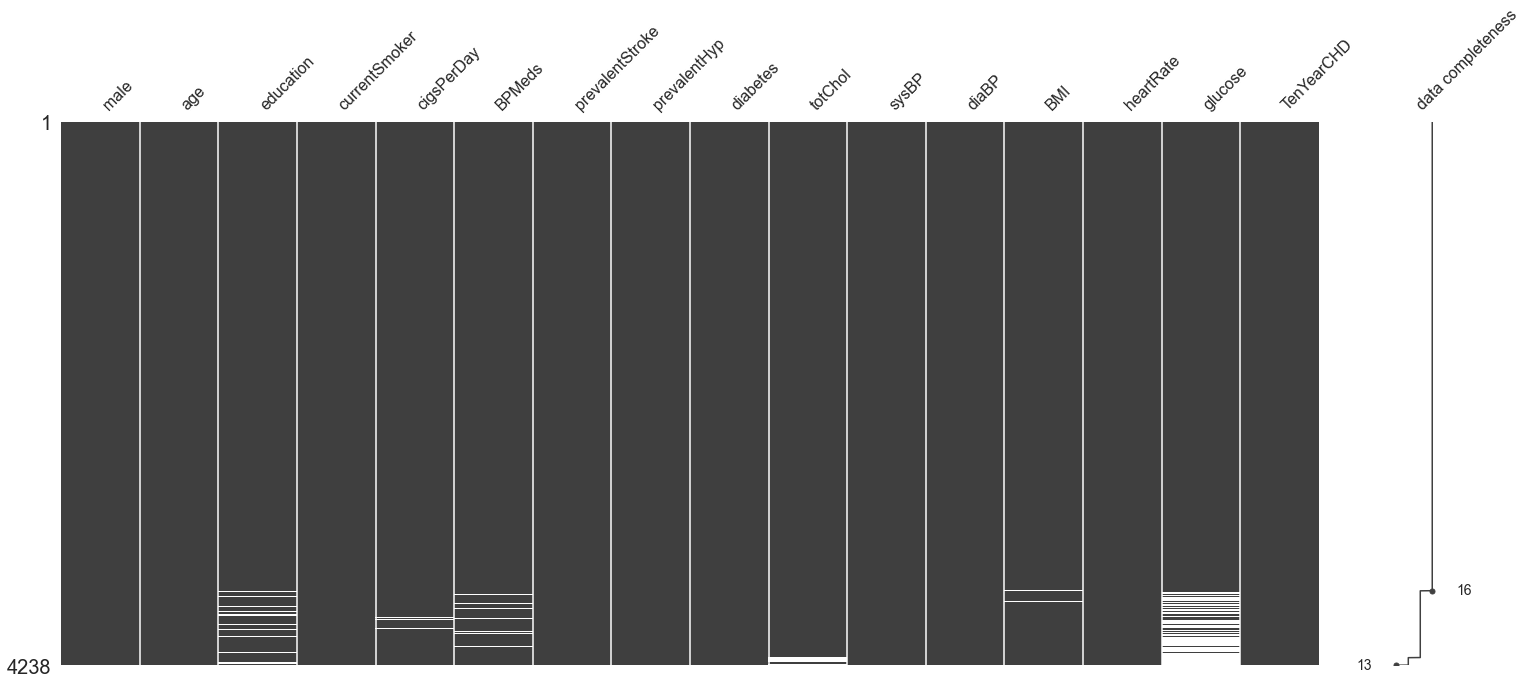

In [106]:
import missingno as msno

msno.matrix(df, labels=True, sort="descending");

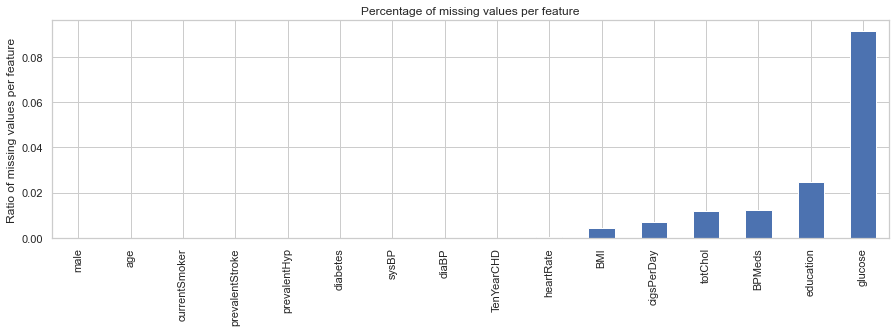

In [107]:
df.isna().mean().sort_values().plot(
    kind="bar", figsize=(15, 4),
    title="Percentage of missing values per feature",
    ylabel="Ratio of missing values per feature");

# la maggior parte dei misssing values sono per la variabile glucose

In [108]:
df.isnull().sum().sum()/len(df)  # rivedere meglio

0.15219443133553562

In [109]:
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})

missing_value_df.sort_values('percent_missing', inplace=True)
missing_value_df

,column_name,percent_missing
male,male,0.000000
age,age,0.000000
currentSmoker,currentSmoker,0.000000
prevalentStroke,prevalentStroke,0.000000
prevalentHyp,prevalentHyp,0.000000
diabetes,diabetes,0.000000
sysBP,sysBP,0.000000
diaBP,diaBP,0.000000
TenYearCHD,TenYearCHD,0.000000
heartRate,heartRate,0.023596


In [110]:
df[df.isna().any(axis=1)]


# I understand that most of the variables with missing numbers are related to medical records and it is better not to impute this type of information.

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
14,0,39,2.0,1,9.0,0.0,0,0,0,226.0,114.0,64.0,22.35,85.0,NaN,0
21,0,43,1.0,0,0.0,0.0,0,0,0,185.0,123.5,77.5,29.89,70.0,NaN,0
26,0,60,1.0,0,0.0,0.0,0,0,0,260.0,110.0,72.5,26.59,65.0,NaN,0
33,1,61,NaN,1,5.0,0.0,0,0,0,175.0,134.0,82.5,18.59,72.0,75.0,1
36,1,56,NaN,0,0.0,0.0,0,0,0,257.0,153.5,102.0,28.09,72.0,75.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4208,0,51,1.0,1,9.0,0.0,0,0,0,340.0,152.0,76.0,25.74,70.0,NaN,0
4229,0,51,3.0,1,20.0,0.0,0,1,0,251.0,140.0,80.0,25.60,75.0,NaN,0
4230,0,56,1.0,1,3.0,0.0,0,1,0,268.0,170.0,102.0,22.89,57.0,NaN,0
4235,0,48,2.0,1,20.0,NaN,0,0,0,248.0,131.0,72.0,22.00,84.0,86.0,0


## Distribuzione variabili

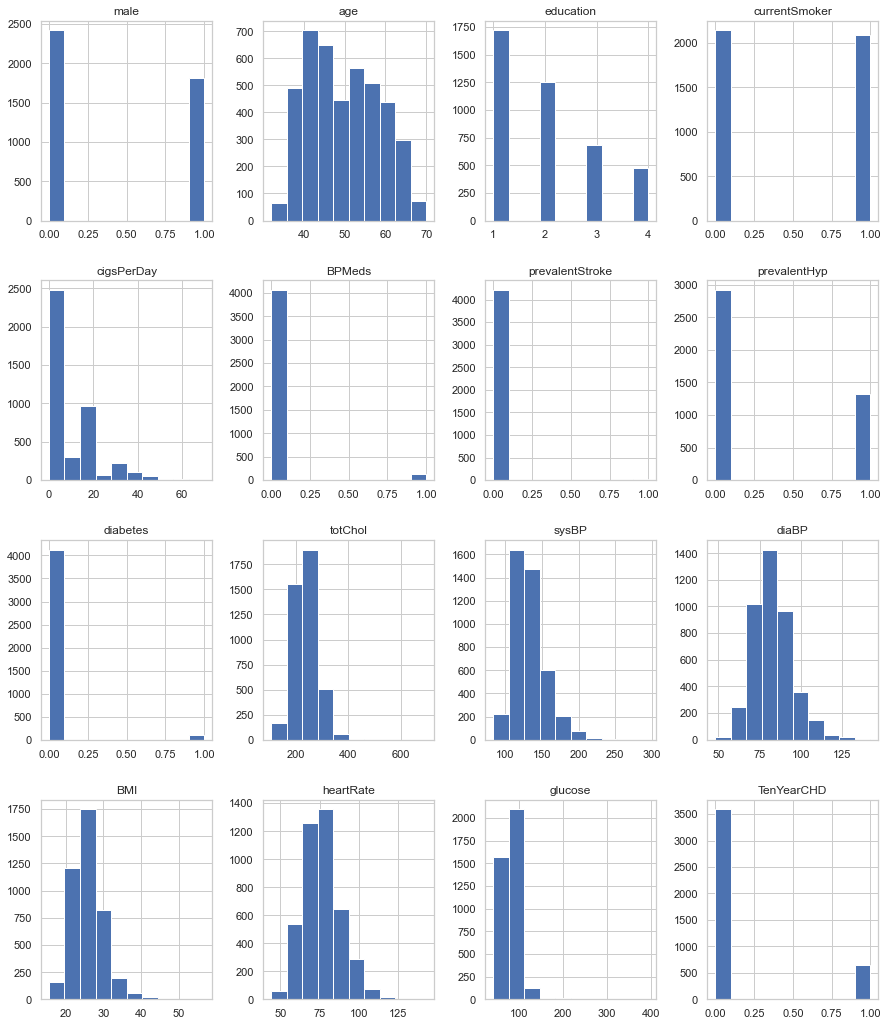

In [111]:
df.hist(figsize=(15,18))
plt.show()

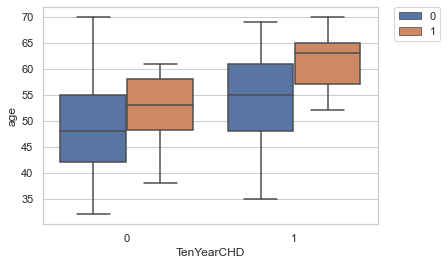

In [112]:
sns.boxplot(x='TenYearCHD',y='age',hue='prevalentStroke',data=df)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# e simili
# https://medium.com/swlh/the-framingham-heart-study-decision-trees-83a7fb62718e

In [113]:
# Checking for outliers
# df.describe()
# sns.pairplot(df)

In [114]:
# considero la variabile target

df.TenYearCHD.value_counts()

0    3594
1     644
Name: TenYearCHD, dtype: int64

## Analisi correlazione

In [115]:
# Calcolo della correlazione
df.corr()


# Visualizzazione della correlazione
# sns.heatmap(df.corr())
#
# f, ax = plt.subplots(figsize=(20,15))
#
# sns.heatmap(df.corr(), annot=True);


# the propensity of developing heart disease is a result of a conjunction of factors.

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
male,1.000000,-0.028979,0.017352,0.197596,0.317930,-0.052506,-0.004546,0.005313,0.015708,-0.070322,-0.035989,0.057933,0.081672,-0.116620,0.006083,0.088428
age,-0.028979,1.000000,-0.165883,-0.213748,-0.192791,0.122995,0.057655,0.307194,0.101258,0.262131,0.394302,0.206104,0.135800,-0.012823,0.122256,0.225256
education,0.017352,-0.165883,1.000000,0.018532,0.008085,-0.010815,-0.035112,-0.081970,-0.038680,-0.023115,-0.129631,-0.062316,-0.137504,-0.054206,-0.035721,-0.054059
currentSmoker,0.197596,-0.213748,0.018532,1.000000,0.769690,-0.048938,-0.032988,-0.103260,-0.044295,-0.046562,-0.130230,-0.107746,-0.167650,0.062356,-0.056826,0.019456
cigsPerDay,0.317930,-0.192791,0.008085,0.769690,1.000000,-0.046134,-0.032707,-0.066146,-0.037067,-0.026320,-0.088780,-0.056632,-0.092856,0.075157,-0.058960,0.057884
BPMeds,-0.052506,0.122995,-0.010815,-0.048938,-0.046134,1.000000,0.117365,0.261187,0.052047,0.080558,0.254219,0.194227,0.100668,0.015233,0.051176,0.087489
prevalentStroke,-0.004546,0.057655,-0.035112,-0.032988,-0.032707,0.117365,1.000000,0.074830,0.006949,0.000067,0.057009,0.045190,0.025891,-0.017676,0.018431,0.061810
prevalentHyp,0.005313,0.307194,-0.081970,-0.103260,-0.066146,0.261187,0.074830,1.000000,0.077808,0.163993,0.696755,0.615751,0.301318,0.147261,0.086834,0.177603
diabetes,0.015708,0.101258,-0.038680,-0.044295,-0.037067,0.052047,0.006949,0.077808,1.000000,0.040278,0.111283,0.050329,0.087036,0.048994,0.617627,0.097317
totChol,-0.070322,0.262131,-0.023115,-0.046562,-0.026320,0.080558,0.000067,0.163993,0.040278,1.000000,0.208908,0.165182,0.115767,0.091125,0.046408,0.082184


# Pre processing

## Gestione missing values

In [116]:
# Dropping all rows with missing data

# As all the variables with missing values have less than 25% of missing information, it will not be considered deleting the whole column but only the rows that contain missing information. I understand that most of the variables with missing numbers are related to medical records and it is better not to impute this type of information.

df_clean = df.dropna()
df_clean.isna().sum()

male               0
age                0
education          0
currentSmoker      0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
glucose            0
TenYearCHD         0
dtype: int64

## Gestione feature

In [117]:
# rendere dummies alcune variabili categoriche
feature_names = ['male', 'education', 'currentSmoker', 'BPMeds',
                 'prevalentStroke', 'prevalentHyp', 'diabetes']

X = df_clean.drop(['TenYearCHD'], axis = 1)
X = pd.get_dummies(X, columns=feature_names)

y = df_clean.TenYearCHD
# X
# è aumentato il numero di collone, 9 feature in più si hanno

# Feature selection: Decision tree

## Divisione train test

 capire se fare prima o dopo class imbalance

In [118]:
from sklearn.model_selection import train_test_split

# clarify what is y and what is x label
# y = df_clean['TenYearCHD']
# X = df_clean.drop(['TenYearCHD'], axis = 1)

# divide train test: 80 % - 20 %
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=123)

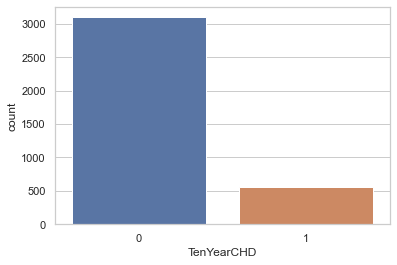

In [119]:
ax = sns.countplot(x=y)

## Gestione class imbalance

Class 0: 3099
Class 1: 557
Proportion: 5.56 : 1


D:\Anaconda\envs\env_fisica\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


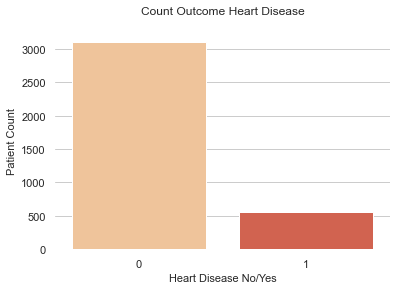

In [120]:
# Checking balance of outcome variable
target_count = df_clean.TenYearCHD.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

sns.countplot(df_clean.TenYearCHD, palette="OrRd")
plt.box(False)
plt.xlabel('Heart Disease No/Yes',fontsize=11)
plt.ylabel('Patient Count',fontsize=11)
plt.title('Count Outcome Heart Disease\n')
plt.show()

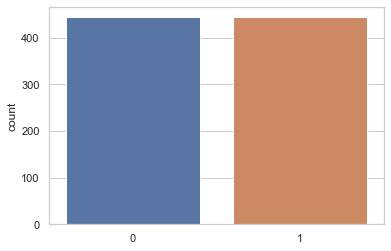

In [121]:
# The easiest way to do so is to randomly select observations from the majority class and remove them from the data set until we achieve a balance between the majority and minority class. -> UNDERSAMPLING

# Undersampling can be defined as removing some observations of the majority class. This is done until the majority and minority class is balanced out.
# Undersampling can be a good choice when you have a ton of data -think millions of rows. But a drawback to undersampling is that we are removing information that may be valuable.

# A number of more sophisticated resampling techniques have been proposed in the scientific literature.
# Let’s apply some of these resampling techniques, using the Python library imbalanced-learn. It is compatible with scikit-learn and is part of scikit-learn-contrib projects.

# alcune tecnicnhe:
# RandomUnderSampler is a fast and easy way to balance the data by randomly selecting a subset of data for the targeted classes. Under-sample the majority class(es) by randomly picking samples with or without replacement.

# NearMiss is an under-sampling technique. Instead of resampling the Minority class, using a distance, this will make the majority class equal to the minority class.


# https://hersanyagci.medium.com/under-sampling-methods-for-imbalanced-data-clustercentroids-randomundersampler-nearmiss-eae0eadcc145
# da fare solo sul train
from imblearn.under_sampling import NearMiss
nr = NearMiss(version=3)

X_train_miss, y_train_miss = nr.fit_sample(X_train, y_train.ravel())  # mentre il test non lo tocco, ora X_train_miss e y_train_miss sono i miei nuovi Train
ax = sns.countplot(x=y_train_miss)

X_train_miss = pd.DataFrame(X_train_miss)
y_train_miss = pd.DataFrame(y_train_miss)
y_train_miss.rename(columns={0: 'TenYearCHD'}, inplace=True)

In [122]:
# train: X_train_miss, y_train_miss è stato ribilanciato
# test: X_test, y_test è rimasto così

In [123]:
# https://towardsdatascience.com/the-5-feature-selection-algorithms-every-data-scientist-need-to-know-3a6b566efd2

In [124]:
# https://towardsdatascience.com/why-how-and-when-to-apply-feature-selection-e9c69adfabf2
# Embedded Methods

# Feature selection can also be acheived by the insights provided by some Machine Learning models.

# Tree based models calculates feature importance for they need to keep the best performing features as close to the root of the tree. Constructing a decision tree involves calculating the best predictive feature.

In [125]:
# test 1

# embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=num_feats)
# embeded_rf_selector.fit(X, y)
#
# embeded_rf_support = embeded_rf_selector.get_support()
# embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()
# print(str(len(embeded_rf_feature)), 'selected features')
# embeded_rf_feature

In [126]:
# test 2
# https://www.youtube.com/watch?v=7v4Qdm5v9aA

## Fit del modello

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from dtreeviz.trees import dtreeviz

dct = DecisionTreeClassifier(max_depth=3)
dct.fit(X_train_miss, y_train_miss)

## Performance

High-Dimensionality Score: 0.5956284153005464


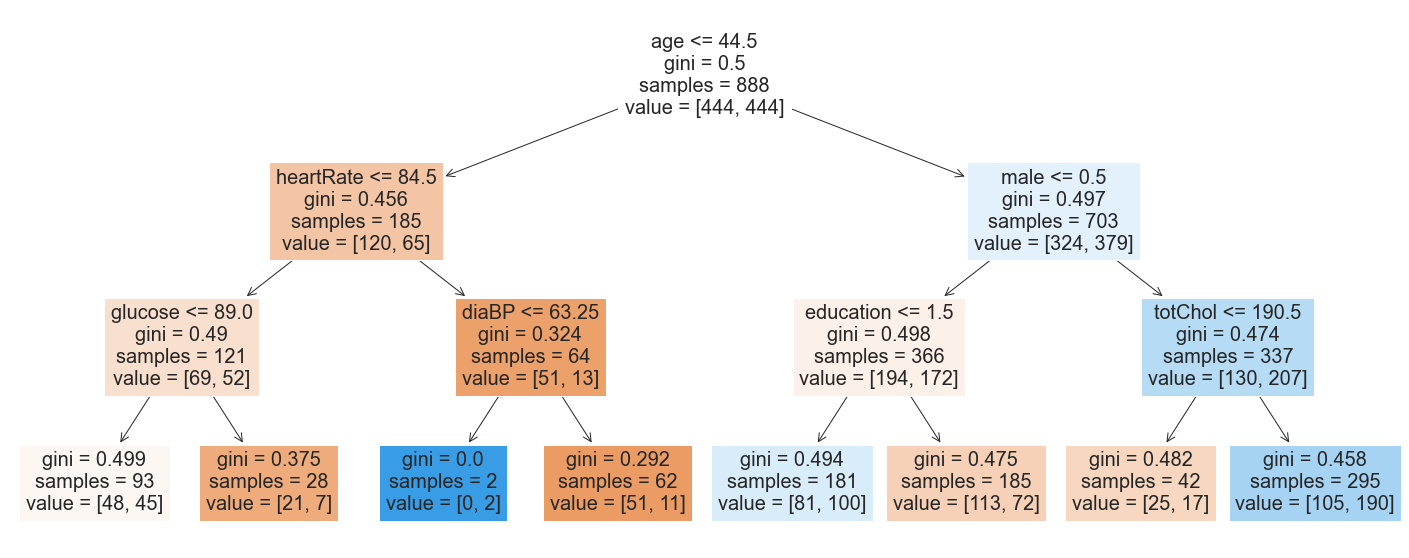

In [127]:
score = dct.score(X_test, y_test)
print("High-Dimensionality Score:", score)



fig = plt.figure(figsize=(25,10))
_ = tree.plot_tree(dct,
                   feature_names=X.columns,
                   filled=True)
plt.show()

In [128]:
dct.feature_importances_

array([0.20295814, 0.28686772, 0.13553642, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.1169711 ,
       0.        , 0.07283314, 0.        , 0.11943938, 0.06539411])

Text(0, 0.5, 'Feature Importance')

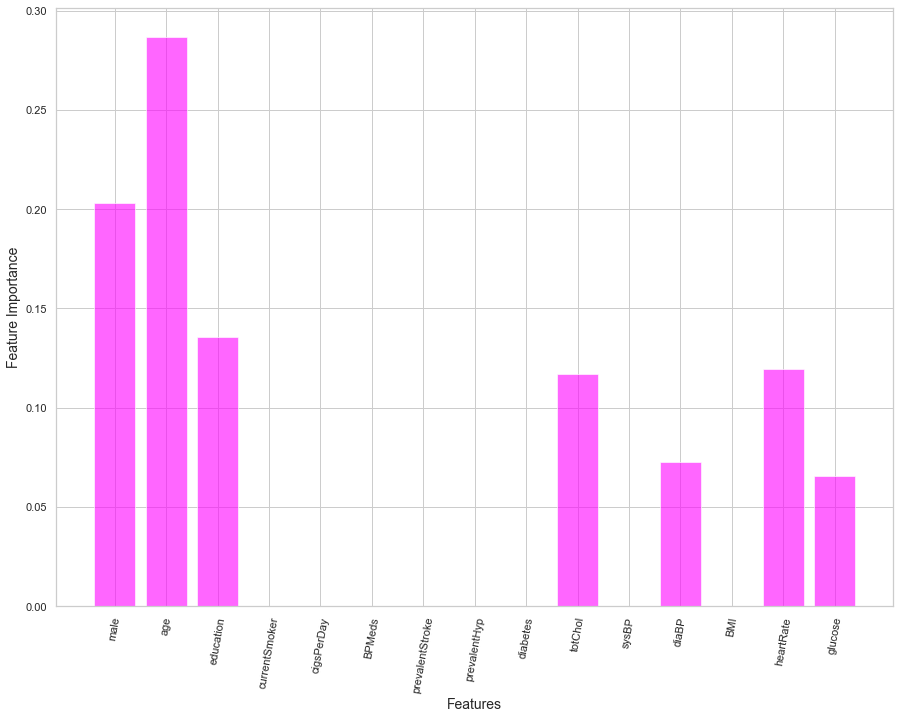

In [129]:
import numpy as np
# features = df_clean.drop(['TenYearCHD'], axis=1)
col_names_list_new = list(X.columns.values)
n_features = len(col_names_list_new)

sns.set(style="whitegrid")

fig = plt.figure(figsize=(15, 11))
fig.tight_layout()
plt.bar(range(n_features), dct.feature_importances_, color="magenta", align="center", alpha=0.6)
plt.xticks(np.arange(n_features), col_names_list_new, rotation=80, fontsize=11)
plt.xlabel("Features", fontsize=14)
plt.ylabel("Feature Importance", fontsize=14)

D:\Anaconda\envs\env_fisica\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


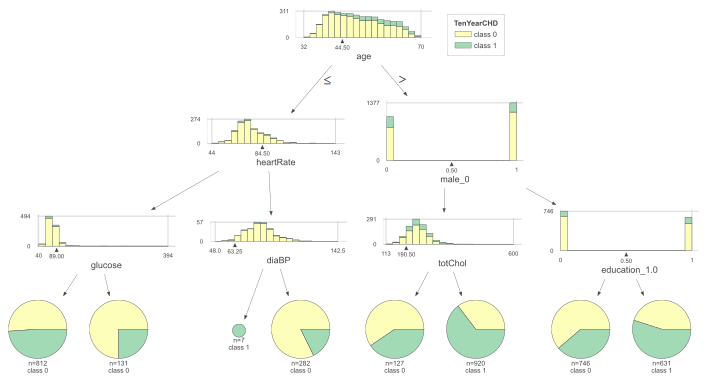

In [91]:
viz = dtreeviz(dct, X, y,
               target_name='TenYearCHD',
               feature_names=list(X.columns))

viz

## Salvataggio albero

# Fetaure selection: boosted decision tree

In [92]:
# # da lezioni
#
# import xgboost as xgb
#
# feature_names = ['age', 'totChol', 'diaBP', 'heartRate', 'glucose', 'male_0']
#
# train = xgb.DMatrix(data=X_train[feature_names],
#                     label=y_train.Label.cat.codes,
#                     missing=-999.0,
#                     feature_names=feature_names)
#
# test = xgb.DMatrix(data=X_test[feature_names],
#                    label=y_test.Label.cat.codes,
#                    missing=-999.0,
#                    feature_names=feature_names)
#
# param = {}
#
# # Booster parameters
# param['eta']              = 0.1 # learning rate
# param['max_depth']        = 10  # maximum depth of a tree
# param['subsample']        = 0.8 # fraction of events to train tree on
# param['colsample_bytree'] = 0.8 # fraction of features to train tree on
#
# # Learning task parameters
# param['objective']   = 'binary:logistic' # objective function
# param['eval_metric'] = 'error'           # evaluation metric for cross validation
# param = list(param.items()) + [('eval_metric', 'logloss')] + [('eval_metric', 'rmse')]
#
# num_trees = 100  # number of trees to make
#
#
# booster = xgb.train(param, train, num_boost_round=num_trees)
#
# predictions = booster.predict(test)
#
# # plot all predictions (both signal and background)
# plt.hist(predictions, bins=np.linspace(0,1,50), histtype='step', color='darkgreen', label='All events')
#
# plt.xlabel('Prediction from BDT', fontsize=12)
# plt.ylabel('Events', fontsize=12)
# plt.legend(frameon=False)
# plt.show()
#
# # plot signal and background separately
# plt.hist(predictions[test.get_label().astype(bool)], bins=np.linspace(0,1,50),
#          histtype='step', color='midnightblue', label='signal')
# plt.hist(predictions[~(test.get_label().astype(bool))], bins=np.linspace(0,1,50),
#          histtype='step', color='firebrick', label='background')
#
# plt.xlabel('Prediction from BDT',fontsize=12)
# plt.ylabel('Events',fontsize=12)
# plt.legend(frameon=False)
# plt.show()
#
# xgb.plot_importance(booster, grid=False);
# plt



In [93]:
# d = data_train.copy()
#
# d['prediction'] = np.around(booster.predict(train)).astype('int64')
# d['prediction'] = d['prediction'].map({1: 's', 0: 'b'})
#
# d[['prediction', 'Label']]
#
# right = d.loc[d['prediction'] == d['Label']]
# wrong = d.loc[d['prediction'] != d['Label']]
#
# true_positive = right.loc[right['prediction'] == 's']
# false_positive = wrong.loc[wrong['prediction'] == 's']
# false_negative = wrong.loc[wrong['prediction'] == 'b']
#
# print("We had %d elements in our recordset." % len(d))
# print("We classified correctly %d events." % len(right))
# print("We classified wrongly %d events." % len(wrong))
# print("We had %d false positive and %d false negative." % (len(false_positive), len(false_negative)))
#
# print("")
#
# print("Our precision has been %1.2f." % (len(true_positive)/(len(true_positive) + len(false_positive))))
# print("Our recall has been %1.2f." % (len(true_positive)/(len(true_positive) + len(false_negative))))
#
#
# # vedi anche notebook lab soluzioni

In [94]:
# from sklearn.feature_selection import SelectFromModel
# from sklearn.ensemble import Decisio
#
# embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=num_feats)
# embeded_rf_selector.fit(X, y)
#
# embeded_rf_support = embeded_rf_selector.get_support()
# embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()
# print(str(len(embeded_rf_feature)), 'selected features')

# Previsione: Logistic Regression

## Selezione feature individuate

In [95]:
# variabili da conisderare
feature_names = ['age', 'totChol', 'diaBP', 'heartRate', 'glucose', 'male_0']

# creo nuovo df solo con variabili selezionate
X = X[feature_names]
y

## Divisione train test

In [ ]:
# del train vecchio seleziono solo le variabili che ci interessano
# ci sta anche ripartire dal dataset e fare operazioni e poi divide in train test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=123)

## Scaling

In [96]:
# per la logistic regression è necessario scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# X = scaler.fit_transform(X)

# eventualmente da fare dopo split
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Gestione class imbalance

In [ ]:
# gestione class imbalance
X_train_miss, y_train_miss = nr.fit_sample(X_train, y_train.ravel())

## Fit del modello

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression

mod = LogisticRegression().fit(X_train_miss, y_train_miss)

## Previsioni

In [ ]:
pred = mod.predict(X_test)

## Performance

In [130]:
# check accuracy: Accuracy: Overall, how often is the classifier correct? Accuracy = (True Pos + True Negative)/total
acc = accuracy_score(y_test, pred)
print(f"The accuracy score for LogReg is: {round(acc,3)*100}%")

# f1 score: The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0.
f1 = f1_score(y_test, pred)
print(f"The f1 score for LogReg is: {round(f1,3)*100}%")

# Precision score: When it predicts yes, how often is it correct? Precision=True Positive/predicted yes
precision = precision_score(y_test, pred)
print(f"The precision score for LogReg is: {round(precision,3)*100}%")

# recall score: True Positive Rate(Sensitivity or Recall): When it’s actually yes, how often does it predict yes? True Positive Rate = True Positive/actual yes
recall = recall_score(y_test, pred)
print(f"The recall score for LogReg is: {round(recall,3)*100}%")

The accuracy score for LogReg is: 60.099999999999994%
The f1 score for LogReg is: 31.1%
The precision score for LogReg is: 21.2%
The recall score for LogReg is: 58.4%


Text(0.5, 1.1, 'Confusion matrix Logistic Regression\n')

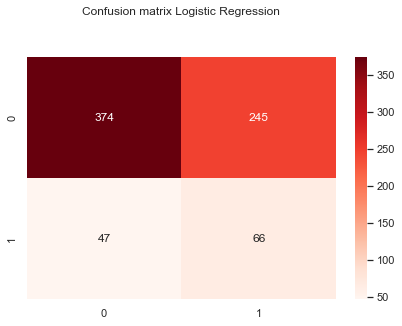

In [98]:
# plotting confusion matrix LogReg

cnf_matrix_log = confusion_matrix(y_test, pred)

sns.heatmap(pd.DataFrame(cnf_matrix_log), annot=True,cmap="Reds" , fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix Logistic Regression\n', y=1.1)